In [36]:
import torch
import torch.nn as nn
import torch.nn.functional
import torch_geometric.nn 
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
import numpy as np
import tqdm
import random
from torch_geometric.nn import GATConv, global_mean_pool
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader


In [37]:
pkl_graphs = pd.read_pickle('/Users/MathildeStouby/Desktop/P5 GitHub/5-semester/Momentum graphs Bayern only.pkl')

In [38]:
unique_nodes = []
for graph in pkl_graphs.values():
    temp = [node for node in graph.nodes() if node not in unique_nodes]
    unique_nodes.extend(temp)

In [39]:
idx_to_pos = dict(enumerate(unique_nodes))
pos_to_idx = {pos : idx for idx, pos in idx_to_pos.items()}

In [40]:
for node, data in graph.nodes(data=True):
    print(f"Node: {node}, Features: {data.get('features')}")

Node: Right Center Back, Features: [0.40995268 0.83633132]
Node: Left Center Back, Features: [0.37577951 0.19785105]
Node: Center Back, Features: [0.3524219  0.56735406]
Node: Center Defensive Midfield, Features: [0.35270904 0.4579695 ]
Node: Right Wing Back, Features: [0.67930475 0.91179797]
Node: Right Center Forward, Features: [0.57427948 0.61344976]
Node: Goalkeeper, Features: [0.         0.43467819]
Node: Left Wing Back, Features: [0.56614998 0.        ]
Node: Left Center Midfield, Features: [0.52749336 0.41509188]
Node: Right Center Midfield, Features: [0.69539249 0.75980712]
Node: Left Center Forward, Features: [1. 1.]


In [41]:
pyg_data = []
thors_kamp = []


for idx, graph in pkl_graphs.items():
    closeness = nx.closeness_centrality(graph)
    betweenness = nx.closeness_centrality(graph)
    pagerank = nx.pagerank(graph, weight='weight')
    centrality_list = [closeness, betweenness, pagerank] 

    adj_dict = nx.to_dict_of_dicts(graph)

    for node in list(graph.nodes()):
        node_features = graph.nodes[node].get('features', np.zeros(2))
        centrality_vect = []
        for measure in centrality_list:
            if node in list(measure.keys()):
                centrality_vect.append(measure[node])
            else:
                centrality_vect.append(0)
        centrality_vect = centrality_vect + node_features.tolist()
        centrality_vect = torch.Tensor(centrality_vect).float()        
        graph.nodes[node]['x'] = centrality_vect

            
    data = from_networkx(graph)

    try:
        data['momentum']
        if idx.startswith('3895275'):
            thors_kamp.append(data)
        else:
            pyg_data.append(data)
    except:
        print(data)


Data(x=[11, 5], edge_index=[2, 22], features=[11, 2], weight=[22])


In [42]:
pyg_data

[Data(x=[11, 5], edge_index=[2, 32], features=[11, 2], weight=[32], momentum=-0.024038370698690414),
 Data(x=[8, 5], edge_index=[2, 18], features=[8, 2], weight=[18], momentum=0.10036080330610275),
 Data(x=[11, 5], edge_index=[2, 33], features=[11, 2], weight=[33], momentum=-0.037643399089574814),
 Data(x=[11, 5], edge_index=[2, 32], features=[11, 2], weight=[32], momentum=0.03450864925980568),
 Data(x=[10, 5], edge_index=[2, 19], features=[10, 2], weight=[19], momentum=0.031030019745230675),
 Data(x=[11, 5], edge_index=[2, 22], features=[11, 2], weight=[22], momentum=-0.017763350158929825),
 Data(x=[9, 5], edge_index=[2, 13], features=[9, 2], weight=[13], momentum=0.0327911302447319),
 Data(x=[11, 5], edge_index=[2, 32], features=[11, 2], weight=[32], momentum=0.10708025842905045),
 Data(x=[11, 5], edge_index=[2, 20], features=[11, 2], weight=[20], momentum=-0.05585882067680359),
 Data(x=[11, 5], edge_index=[2, 21], features=[11, 2], weight=[21], momentum=0.05494511127471924),
 Data(x

In [61]:
import numpy as np
from scipy import stats

# Example list of values
data = [1.2, 1.5, 1.3, 1.7, 1.4, 1.6, 1.8, 1.5, 1.7, 1.6]

# Convert to numpy array for convenience
data = scores

# Calculate mean and standard error of the mean
mean = np.mean(data)
sem = stats.sem(data)  # Standard error of the mean

# Confidence level: 95%
confidence_level = 0.95
degrees_freedom = len(data) - 1
t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)  # t-critical value

# Margin of error
margin_of_error = t_value * sem

# Confidence interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

print(f"Mean: {mean:.4f}")
print(f"95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

Mean: -0.1015
95% Confidence Interval: (-0.1255, -0.0775)


In [ ]:
train_idx = random.sample(range(len(pyg_data)), int(len(pyg_data) * 0.8))
test_idx = [i for i in range(len(pyg_data)) if i not in train_idx]
train_data = [pyg_data[idx] for idx in train_idx]
dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1= GATConv(input_dim, hidden_dim, heads=num_heads, edge_dim=1)
        self.layer2= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
        self.layer3= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, edge_dim=1)
        #self.layer4= GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.layer5 = GATConv(hidden_dim * num_heads, output_dim, heads=1, edge_dim=1, concat=False)
        self.activation_function = nn.ReLU()
            
    def forward(self, input, edge_index, edge_attr, batch):
        output = self.activation_function(self.layer1(input, edge_index, edge_attr))
        output = self.activation_function(self.layer2(output, edge_index, edge_attr))
        output = self.activation_function(self.layer3(output, edge_index, edge_attr))
        #output = self.activation_function(self.layer4(output, edge_index, edge_attr))
        output = self.layer5(output, edge_index, edge_attr)
        output = global_mean_pool(output, batch)
        return output
    

input_dim = 5
lr = 0.01
epochs_num = 100

scores = []
for i in range(30):
    gat = GAT(input_dim = input_dim, hidden_dim = 12, output_dim = 1, num_heads = 6)
    optimizer = torch.optim.SGD(gat.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    
    for epoch in tqdm.tqdm(range(epochs_num)):
        
        epoch_loss = 0
        for batch in tqdm.tqdm(dataloader):
            # Forward pass
            optimizer.zero_grad()
            
            output = gat(batch.x, batch.edge_index, batch.weight, batch.batch)
            
            # Calculate loss
            loss = loss_fn(output, batch.momentum)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(gat.parameters(), max_norm=2.0) 

            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}") 
    gat.eval() 
    y_pred  = []
    y_true = []

    with torch.no_grad():
        for idx in test_idx:
            batch = torch.zeros(pyg_data[idx].x.size(0), dtype=torch.long)
            output = gat(pyg_data[idx].x, pyg_data[idx].edge_index, pyg_data[idx].weight, batch)
            y_pred.append(output.item())
            y_true.append(pyg_data[idx].momentum)
            
    from sklearn.metrics import r2_score
    scores.append(r2_score(y_true, y_pred))
    print(scores)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:03,  2.40it/s]

Epoch 1, Loss: 0.0105


 20%|██        | 2/10 [00:00<00:02,  3.74it/s]

Epoch 2, Loss: 0.0080


 30%|███       | 3/10 [00:00<00:01,  4.06it/s]

Epoch 3, Loss: 0.0072


 40%|████      | 4/10 [00:00<00:01,  4.57it/s]

Epoch 4, Loss: 0.0070


 50%|█████     | 5/10 [00:01<00:01,  4.89it/s]

Epoch 5, Loss: 0.0070


 60%|██████    | 6/10 [00:01<00:00,  5.02it/s]

Epoch 6, Loss: 0.0071


 70%|███████   | 7/10 [00:01<00:00,  5.50it/s]

Epoch 7, Loss: 0.0069


 80%|████████  | 8/10 [00:01<00:00,  5.84it/s]

Epoch 8, Loss: 0.0071


 90%|█████████ | 9/10 [00:01<00:00,  5.51it/s]

Epoch 9, Loss: 0.0070


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.99it/s]

Epoch 1, Loss: 0.0093


 20%|██        | 2/10 [00:00<00:01,  6.15it/s]

Epoch 2, Loss: 0.0075


 30%|███       | 3/10 [00:00<00:01,  6.36it/s]

Epoch 3, Loss: 0.0070


 40%|████      | 4/10 [00:00<00:00,  6.57it/s]

Epoch 4, Loss: 0.0066


 50%|█████     | 5/10 [00:00<00:00,  6.22it/s]

Epoch 5, Loss: 0.0070


 60%|██████    | 6/10 [00:00<00:00,  6.13it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.41it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  6.03it/s]

Epoch 8, Loss: 0.0070


 90%|█████████ | 9/10 [00:01<00:00,  6.20it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.67it/s]

Epoch 1, Loss: 0.0069


 20%|██        | 2/10 [00:00<00:01,  7.08it/s]

Epoch 2, Loss: 0.0068


 30%|███       | 3/10 [00:00<00:01,  5.44it/s]

Epoch 3, Loss: 0.0068


 40%|████      | 4/10 [00:00<00:01,  5.89it/s]

Epoch 4, Loss: 0.0069


 50%|█████     | 5/10 [00:00<00:00,  6.43it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  6.19it/s]

Epoch 6, Loss: 0.0067


 70%|███████   | 7/10 [00:01<00:00,  6.25it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.37it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  6.03it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Epoch 10, Loss: 0.0069
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  4.97it/s]

Epoch 1, Loss: 0.0153


 20%|██        | 2/10 [00:00<00:01,  5.07it/s]

Epoch 2, Loss: 0.0096


 30%|███       | 3/10 [00:00<00:01,  5.86it/s]

Epoch 3, Loss: 0.0080


 40%|████      | 4/10 [00:00<00:00,  6.11it/s]

Epoch 4, Loss: 0.0076


 50%|█████     | 5/10 [00:00<00:00,  5.32it/s]

Epoch 5, Loss: 0.0073


 60%|██████    | 6/10 [00:01<00:00,  5.91it/s]

Epoch 6, Loss: 0.0072


 70%|███████   | 7/10 [00:01<00:00,  6.38it/s]

Epoch 7, Loss: 0.0072


 80%|████████  | 8/10 [00:01<00:00,  6.05it/s]

Epoch 8, Loss: 0.0073


 90%|█████████ | 9/10 [00:01<00:00,  6.44it/s]

Epoch 9, Loss: 0.0073


100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Epoch 10, Loss: 0.0072
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.09it/s]

Epoch 1, Loss: 0.0088


 20%|██        | 2/10 [00:00<00:01,  7.32it/s]

Epoch 2, Loss: 0.0078


 30%|███       | 3/10 [00:00<00:01,  6.46it/s]

Epoch 3, Loss: 0.0073


 40%|████      | 4/10 [00:00<00:00,  6.63it/s]

Epoch 4, Loss: 0.0071


 50%|█████     | 5/10 [00:00<00:00,  6.60it/s]

Epoch 5, Loss: 0.0069


 60%|██████    | 6/10 [00:00<00:00,  6.20it/s]

Epoch 6, Loss: 0.0067


 70%|███████   | 7/10 [00:01<00:00,  6.65it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.98it/s]

Epoch 8, Loss: 0.0067


 90%|█████████ | 9/10 [00:01<00:00,  6.57it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.30it/s]

Epoch 1, Loss: 0.0158


 20%|██        | 2/10 [00:00<00:01,  6.29it/s]

Epoch 2, Loss: 0.0102


 30%|███       | 3/10 [00:00<00:01,  6.72it/s]

Epoch 3, Loss: 0.0081


 40%|████      | 4/10 [00:00<00:00,  7.08it/s]

Epoch 4, Loss: 0.0075


 50%|█████     | 5/10 [00:00<00:00,  6.64it/s]

Epoch 5, Loss: 0.0071


 60%|██████    | 6/10 [00:00<00:00,  6.86it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:01<00:00,  6.88it/s]

Epoch 7, Loss: 0.0070


 80%|████████  | 8/10 [00:01<00:00,  6.37it/s]

Epoch 8, Loss: 0.0071


 90%|█████████ | 9/10 [00:01<00:00,  6.63it/s]

Epoch 9, Loss: 0.0070


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Epoch 10, Loss: 0.0070
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.63it/s]

Epoch 1, Loss: 0.0088


 20%|██        | 2/10 [00:00<00:01,  6.43it/s]

Epoch 2, Loss: 0.0075


 30%|███       | 3/10 [00:00<00:01,  6.07it/s]

Epoch 3, Loss: 0.0069


 40%|████      | 4/10 [00:00<00:00,  6.48it/s]

Epoch 4, Loss: 0.0068


 50%|█████     | 5/10 [00:00<00:00,  6.41it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  5.85it/s]

Epoch 6, Loss: 0.0065


 70%|███████   | 7/10 [00:01<00:00,  5.95it/s]

Epoch 7, Loss: 0.0066


 80%|████████  | 8/10 [00:01<00:00,  6.11it/s]

Epoch 8, Loss: 0.0067


 90%|█████████ | 9/10 [00:01<00:00,  5.81it/s]

Epoch 9, Loss: 0.0065


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.43it/s]

Epoch 1, Loss: 0.0078


 20%|██        | 2/10 [00:00<00:01,  5.97it/s]

Epoch 2, Loss: 0.0070


 30%|███       | 3/10 [00:00<00:01,  6.06it/s]

Epoch 3, Loss: 0.0070


 40%|████      | 4/10 [00:00<00:00,  6.37it/s]

Epoch 4, Loss: 0.0068


 50%|█████     | 5/10 [00:00<00:00,  6.10it/s]

Epoch 5, Loss: 0.0068


 60%|██████    | 6/10 [00:00<00:00,  6.41it/s]

Epoch 6, Loss: 0.0071


 70%|███████   | 7/10 [00:01<00:00,  6.58it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.20it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  6.41it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.56it/s]

Epoch 1, Loss: 0.0122


 20%|██        | 2/10 [00:00<00:01,  6.61it/s]

Epoch 2, Loss: 0.0089


 30%|███       | 3/10 [00:00<00:01,  5.77it/s]

Epoch 3, Loss: 0.0075


 40%|████      | 4/10 [00:00<00:00,  6.30it/s]

Epoch 4, Loss: 0.0069


 50%|█████     | 5/10 [00:00<00:00,  6.43it/s]

Epoch 5, Loss: 0.0069


 60%|██████    | 6/10 [00:00<00:00,  6.03it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.34it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  6.50it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  5.96it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.78it/s]

Epoch 1, Loss: 0.0335


 20%|██        | 2/10 [00:00<00:01,  5.97it/s]

Epoch 2, Loss: 0.0149


 30%|███       | 3/10 [00:00<00:01,  6.27it/s]

Epoch 3, Loss: 0.0094


 40%|████      | 4/10 [00:00<00:00,  6.27it/s]

Epoch 4, Loss: 0.0078


 50%|█████     | 5/10 [00:00<00:00,  5.99it/s]

Epoch 5, Loss: 0.0074


 60%|██████    | 6/10 [00:00<00:00,  6.25it/s]

Epoch 6, Loss: 0.0073


 70%|███████   | 7/10 [00:01<00:00,  5.54it/s]

Epoch 7, Loss: 0.0072


 80%|████████  | 8/10 [00:01<00:00,  5.50it/s]

Epoch 8, Loss: 0.0071


 90%|█████████ | 9/10 [00:01<00:00,  5.86it/s]

Epoch 9, Loss: 0.0071


100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Epoch 10, Loss: 0.0071
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.97it/s]

Epoch 1, Loss: 0.0080


 20%|██        | 2/10 [00:00<00:01,  7.37it/s]

Epoch 2, Loss: 0.0073


 30%|███       | 3/10 [00:00<00:01,  6.34it/s]

Epoch 3, Loss: 0.0072


 40%|████      | 4/10 [00:00<00:00,  6.55it/s]

Epoch 4, Loss: 0.0069


 50%|█████     | 5/10 [00:00<00:00,  6.45it/s]

Epoch 5, Loss: 0.0068


 60%|██████    | 6/10 [00:00<00:00,  6.21it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:01<00:00,  6.48it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.73it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  6.37it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.36it/s]

Epoch 1, Loss: 0.0121


 20%|██        | 2/10 [00:00<00:01,  6.27it/s]

Epoch 2, Loss: 0.0083


 30%|███       | 3/10 [00:00<00:01,  6.83it/s]

Epoch 3, Loss: 0.0071


 40%|████      | 4/10 [00:00<00:00,  6.70it/s]

Epoch 4, Loss: 0.0069


 50%|█████     | 5/10 [00:00<00:00,  6.12it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  6.22it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.19it/s]

Epoch 7, Loss: 0.0069


 80%|████████  | 8/10 [00:01<00:00,  5.56it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  5.80it/s]

Epoch 9, Loss: 0.0066


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch 10, Loss: 0.0069
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.63it/s]

Epoch 1, Loss: 0.0149


 20%|██        | 2/10 [00:00<00:01,  6.53it/s]

Epoch 2, Loss: 0.0096


 30%|███       | 3/10 [00:00<00:01,  5.77it/s]

Epoch 3, Loss: 0.0078


 40%|████      | 4/10 [00:00<00:00,  6.13it/s]

Epoch 4, Loss: 0.0071


 50%|█████     | 5/10 [00:00<00:00,  6.01it/s]

Epoch 5, Loss: 0.0070


 60%|██████    | 6/10 [00:01<00:00,  5.62it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:01<00:00,  5.72it/s]

Epoch 7, Loss: 0.0070


 80%|████████  | 8/10 [00:01<00:00,  6.03it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  5.73it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.59it/s]

Epoch 1, Loss: 0.0174


 20%|██        | 2/10 [00:00<00:01,  5.58it/s]

Epoch 2, Loss: 0.0102


 30%|███       | 3/10 [00:00<00:01,  5.92it/s]

Epoch 3, Loss: 0.0079


 40%|████      | 4/10 [00:00<00:00,  6.19it/s]

Epoch 4, Loss: 0.0073


 50%|█████     | 5/10 [00:00<00:00,  5.64it/s]

Epoch 5, Loss: 0.0071


 60%|██████    | 6/10 [00:01<00:00,  5.88it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:01<00:00,  6.09it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  5.47it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  5.79it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch 10, Loss: 0.0066
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.93it/s]

Epoch 1, Loss: 0.0070


 20%|██        | 2/10 [00:00<00:01,  6.75it/s]

Epoch 2, Loss: 0.0069


 30%|███       | 3/10 [00:00<00:01,  6.01it/s]

Epoch 3, Loss: 0.0067


 40%|████      | 4/10 [00:00<00:00,  6.26it/s]

Epoch 4, Loss: 0.0068


 50%|█████     | 5/10 [00:00<00:00,  6.26it/s]

Epoch 5, Loss: 0.0068


 60%|██████    | 6/10 [00:00<00:00,  5.74it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.05it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.17it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  5.85it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch 10, Loss: 0.0065
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.12it/s]

Epoch 1, Loss: 0.0122


 20%|██        | 2/10 [00:00<00:01,  5.41it/s]

Epoch 2, Loss: 0.0085


 30%|███       | 3/10 [00:00<00:01,  5.95it/s]

Epoch 3, Loss: 0.0074


 40%|████      | 4/10 [00:00<00:00,  6.16it/s]

Epoch 4, Loss: 0.0071


 50%|█████     | 5/10 [00:00<00:00,  5.66it/s]

Epoch 5, Loss: 0.0069


 60%|██████    | 6/10 [00:01<00:00,  5.90it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.17it/s]

Epoch 7, Loss: 0.0071


 80%|████████  | 8/10 [00:01<00:00,  5.82it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  6.05it/s]

Epoch 9, Loss: 0.0069


100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Epoch 10, Loss: 0.0070
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.62it/s]

Epoch 1, Loss: 0.0079


 20%|██        | 2/10 [00:00<00:01,  6.59it/s]

Epoch 2, Loss: 0.0073


 30%|███       | 3/10 [00:00<00:01,  5.81it/s]

Epoch 3, Loss: 0.0068


 40%|████      | 4/10 [00:00<00:00,  6.17it/s]

Epoch 4, Loss: 0.0069


 50%|█████     | 5/10 [00:00<00:00,  6.24it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  5.85it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:01<00:00,  6.15it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.49it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  6.16it/s]

Epoch 9, Loss: 0.0066


100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.59it/s]

Epoch 1, Loss: 0.0069


 20%|██        | 2/10 [00:00<00:01,  6.20it/s]

Epoch 2, Loss: 0.0068


 30%|███       | 3/10 [00:00<00:01,  6.56it/s]

Epoch 3, Loss: 0.0068


 40%|████      | 4/10 [00:00<00:00,  6.95it/s]

Epoch 4, Loss: 0.0067


 50%|█████     | 5/10 [00:00<00:00,  6.39it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  6.49it/s]

Epoch 6, Loss: 0.0066


 70%|███████   | 7/10 [00:01<00:00,  6.46it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  5.57it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  5.90it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Epoch 10, Loss: 0.0066
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.78it/s]

Epoch 1, Loss: 0.0300


 20%|██        | 2/10 [00:00<00:01,  7.09it/s]

Epoch 2, Loss: 0.0150


 30%|███       | 3/10 [00:00<00:01,  6.17it/s]

Epoch 3, Loss: 0.0099


 40%|████      | 4/10 [00:00<00:00,  6.44it/s]

Epoch 4, Loss: 0.0080


 50%|█████     | 5/10 [00:00<00:00,  6.52it/s]

Epoch 5, Loss: 0.0074


 60%|██████    | 6/10 [00:00<00:00,  6.16it/s]

Epoch 6, Loss: 0.0070


 70%|███████   | 7/10 [00:01<00:00,  6.17it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  6.29it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  5.95it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.92it/s]

Epoch 1, Loss: 0.0162


 20%|██        | 2/10 [00:00<00:01,  5.87it/s]

Epoch 2, Loss: 0.0105


 30%|███       | 3/10 [00:00<00:01,  6.21it/s]

Epoch 3, Loss: 0.0084


 40%|████      | 4/10 [00:00<00:00,  6.61it/s]

Epoch 4, Loss: 0.0075


 50%|█████     | 5/10 [00:00<00:00,  6.21it/s]

Epoch 5, Loss: 0.0073


 60%|██████    | 6/10 [00:00<00:00,  6.36it/s]

Epoch 6, Loss: 0.0071


 70%|███████   | 7/10 [00:01<00:00,  6.59it/s]

Epoch 7, Loss: 0.0070


 80%|████████  | 8/10 [00:01<00:00,  6.12it/s]

Epoch 8, Loss: 0.0072


 90%|█████████ | 9/10 [00:01<00:00,  6.42it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.88it/s]

Epoch 1, Loss: 0.0070


 20%|██        | 2/10 [00:00<00:01,  6.79it/s]

Epoch 2, Loss: 0.0068


 30%|███       | 3/10 [00:00<00:01,  5.34it/s]

Epoch 3, Loss: 0.0068


 40%|████      | 4/10 [00:00<00:01,  5.62it/s]

Epoch 4, Loss: 0.0069


 50%|█████     | 5/10 [00:00<00:00,  6.07it/s]

Epoch 5, Loss: 0.0068


 60%|██████    | 6/10 [00:01<00:00,  5.83it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.13it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.30it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  5.91it/s]

Epoch 9, Loss: 0.0069


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.99it/s]

Epoch 1, Loss: 0.0072


 20%|██        | 2/10 [00:00<00:01,  5.54it/s]

Epoch 2, Loss: 0.0068


 30%|███       | 3/10 [00:00<00:01,  6.02it/s]

Epoch 3, Loss: 0.0068


 40%|████      | 4/10 [00:00<00:00,  6.38it/s]

Epoch 4, Loss: 0.0066


 50%|█████     | 5/10 [00:00<00:00,  6.12it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  6.32it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:01<00:00,  6.61it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  6.19it/s]

Epoch 8, Loss: 0.0067


 90%|█████████ | 9/10 [00:01<00:00,  6.18it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Epoch 10, Loss: 0.0068
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.68it/s]

Epoch 1, Loss: 0.0069


 20%|██        | 2/10 [00:00<00:01,  6.57it/s]

Epoch 2, Loss: 0.0068


 30%|███       | 3/10 [00:00<00:01,  5.90it/s]

Epoch 3, Loss: 0.0066


 40%|████      | 4/10 [00:00<00:00,  6.09it/s]

Epoch 4, Loss: 0.0066


 50%|█████     | 5/10 [00:00<00:00,  6.39it/s]

Epoch 5, Loss: 0.0066


 60%|██████    | 6/10 [00:00<00:00,  6.04it/s]

Epoch 6, Loss: 0.0067


 70%|███████   | 7/10 [00:01<00:00,  6.38it/s]

Epoch 7, Loss: 0.0068


 80%|████████  | 8/10 [00:01<00:00,  6.64it/s]

Epoch 8, Loss: 0.0067


 90%|█████████ | 9/10 [00:01<00:00,  6.14it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.99it/s]

Epoch 1, Loss: 0.0157


 20%|██        | 2/10 [00:00<00:01,  5.89it/s]

Epoch 2, Loss: 0.0105


 30%|███       | 3/10 [00:00<00:01,  6.12it/s]

Epoch 3, Loss: 0.0083


 40%|████      | 4/10 [00:00<00:00,  6.42it/s]

Epoch 4, Loss: 0.0075


 50%|█████     | 5/10 [00:00<00:00,  5.96it/s]

Epoch 5, Loss: 0.0070


 60%|██████    | 6/10 [00:00<00:00,  6.14it/s]

Epoch 6, Loss: 0.0069


 70%|███████   | 7/10 [00:01<00:00,  6.43it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  6.11it/s]

Epoch 8, Loss: 0.0067


 90%|█████████ | 9/10 [00:01<00:00,  6.12it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Epoch 10, Loss: 0.0066
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

Epoch 1, Loss: 0.0070


 20%|██        | 2/10 [00:00<00:01,  7.24it/s]

Epoch 2, Loss: 0.0070


 30%|███       | 3/10 [00:00<00:01,  6.28it/s]

Epoch 3, Loss: 0.0070


 40%|████      | 4/10 [00:00<00:00,  6.35it/s]

Epoch 4, Loss: 0.0068


 50%|█████     | 5/10 [00:00<00:00,  6.31it/s]

Epoch 5, Loss: 0.0070


 60%|██████    | 6/10 [00:00<00:00,  5.82it/s]

Epoch 6, Loss: 0.0070


 70%|███████   | 7/10 [00:01<00:00,  6.08it/s]

Epoch 7, Loss: 0.0070


 80%|████████  | 8/10 [00:01<00:00,  6.40it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  6.05it/s]

Epoch 9, Loss: 0.0068


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


Epoch 10, Loss: 0.0070
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846, -0.0353459046359792]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.79it/s]

Epoch 1, Loss: 0.0099


 20%|██        | 2/10 [00:00<00:01,  7.36it/s]

Epoch 2, Loss: 0.0078


 30%|███       | 3/10 [00:00<00:01,  6.62it/s]

Epoch 3, Loss: 0.0070


 40%|████      | 4/10 [00:00<00:00,  7.07it/s]

Epoch 4, Loss: 0.0067


 50%|█████     | 5/10 [00:00<00:00,  7.33it/s]

Epoch 5, Loss: 0.0065


 60%|██████    | 6/10 [00:00<00:00,  6.96it/s]

Epoch 6, Loss: 0.0067


 70%|███████   | 7/10 [00:00<00:00,  6.98it/s]

Epoch 7, Loss: 0.0066


 80%|████████  | 8/10 [00:01<00:00,  7.23it/s]

Epoch 8, Loss: 0.0066


 90%|█████████ | 9/10 [00:01<00:00,  7.47it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846, -0.0353459046359792, -0.09855045049235223]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.91it/s]

Epoch 1, Loss: 0.0131


 20%|██        | 2/10 [00:00<00:01,  7.41it/s]

Epoch 2, Loss: 0.0087


 30%|███       | 3/10 [00:00<00:00,  7.52it/s]

Epoch 3, Loss: 0.0075


 40%|████      | 4/10 [00:00<00:00,  7.42it/s]

Epoch 4, Loss: 0.0070


 50%|█████     | 5/10 [00:00<00:00,  7.40it/s]

Epoch 5, Loss: 0.0072


 60%|██████    | 6/10 [00:00<00:00,  7.49it/s]

Epoch 6, Loss: 0.0070


 70%|███████   | 7/10 [00:00<00:00,  6.82it/s]

Epoch 7, Loss: 0.0070


 80%|████████  | 8/10 [00:01<00:00,  7.15it/s]

Epoch 8, Loss: 0.0071


 90%|█████████ | 9/10 [00:01<00:00,  7.06it/s]

Epoch 9, Loss: 0.0069


100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


Epoch 10, Loss: 0.0071
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846, -0.0353459046359792, -0.09855045049235223, -0.11388740902467243]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  6.51it/s]

Epoch 1, Loss: 0.0069


 20%|██        | 2/10 [00:00<00:01,  5.86it/s]

Epoch 2, Loss: 0.0068


 30%|███       | 3/10 [00:00<00:01,  5.80it/s]

Epoch 3, Loss: 0.0066


 40%|████      | 4/10 [00:00<00:00,  6.29it/s]

Epoch 4, Loss: 0.0067


 50%|█████     | 5/10 [00:00<00:00,  6.74it/s]

Epoch 5, Loss: 0.0067


 60%|██████    | 6/10 [00:00<00:00,  7.16it/s]

Epoch 6, Loss: 0.0071


 70%|███████   | 7/10 [00:01<00:00,  7.44it/s]

Epoch 7, Loss: 0.0067


 80%|████████  | 8/10 [00:01<00:00,  7.57it/s]

Epoch 8, Loss: 0.0068


 90%|█████████ | 9/10 [00:01<00:00,  7.62it/s]

Epoch 9, Loss: 0.0069


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846, -0.0353459046359792, -0.09855045049235223, -0.11388740902467243, -0.049144829359446085]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.94it/s]

Epoch 1, Loss: 0.0076


 20%|██        | 2/10 [00:00<00:01,  7.88it/s]

Epoch 2, Loss: 0.0070


 30%|███       | 3/10 [00:00<00:00,  7.76it/s]

Epoch 3, Loss: 0.0068


 40%|████      | 4/10 [00:00<00:00,  7.54it/s]

Epoch 4, Loss: 0.0068


 50%|█████     | 5/10 [00:00<00:00,  7.40it/s]

Epoch 5, Loss: 0.0069


 60%|██████    | 6/10 [00:00<00:00,  6.73it/s]

Epoch 6, Loss: 0.0068


 70%|███████   | 7/10 [00:00<00:00,  6.82it/s]

Epoch 7, Loss: 0.0066


 80%|████████  | 8/10 [00:01<00:00,  7.15it/s]

Epoch 8, Loss: 0.0069


 90%|█████████ | 9/10 [00:01<00:00,  7.20it/s]

Epoch 9, Loss: 0.0067


100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


Epoch 10, Loss: 0.0067
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846, -0.0353459046359792, -0.09855045049235223, -0.11388740902467243, -0.049144829359446085, -0.06526290047320371]


  0%|          | 0/10 [00:00<?, ?it/s]/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/MathildeStouby/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:00<00:01,  7.26it/s]

Epoch 1, Loss: 0.0549


 20%|██        | 2/10 [00:00<00:01,  5.97it/s]

Epoch 2, Loss: 0.0177


 30%|███       | 3/10 [00:00<00:01,  6.56it/s]

Epoch 3, Loss: 0.0099


 40%|████      | 4/10 [00:00<00:00,  6.99it/s]

Epoch 4, Loss: 0.0080


 50%|█████     | 5/10 [00:00<00:00,  7.21it/s]

Epoch 5, Loss: 0.0075


 60%|██████    | 6/10 [00:00<00:00,  7.31it/s]

Epoch 6, Loss: 0.0075


 70%|███████   | 7/10 [00:01<00:00,  7.14it/s]

Epoch 7, Loss: 0.0073


 80%|████████  | 8/10 [00:01<00:00,  7.34it/s]

Epoch 8, Loss: 0.0072


 90%|█████████ | 9/10 [00:01<00:00,  6.57it/s]

Epoch 9, Loss: 0.0073


100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


Epoch 10, Loss: 0.0072
[-0.04107220042757276, -0.16341925429347448, -0.0805527281216849, -0.01383803573254383, -0.1458905138569333, 0.003991120209600796, -0.08473416673505318, -0.0709857375357359, -0.16760981921295914, -0.204776789951149, -0.14512952489100517, -0.13120356535120847, -0.17715514817134737, -0.19104165941538187, -0.09287817013664101, -0.019152744647513265, -0.05550861737165769, -0.06634104092098081, -0.19215204117389972, -0.21853283980272842, -0.08412540853138695, -0.09774334633086856, -0.08907761320491536, -0.16510877352036846, -0.0353459046359792, -0.09855045049235223, -0.11388740902467243, -0.049144829359446085, -0.06526290047320371, 0.011450440412985485]


In [263]:
y_pred  = []
y_true = []

with torch.no_grad():
    for idx in test_idx:
        batch = torch.zeros(pyg_data[idx].x.size(0), dtype=torch.long)
        output = gat(pyg_data[idx].x, pyg_data[idx].edge_index, pyg_data[idx].weight, batch)
        y_pred.append(output.item())
        y_true.append(pyg_data[idx].momentum)
        
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.03125853053911398

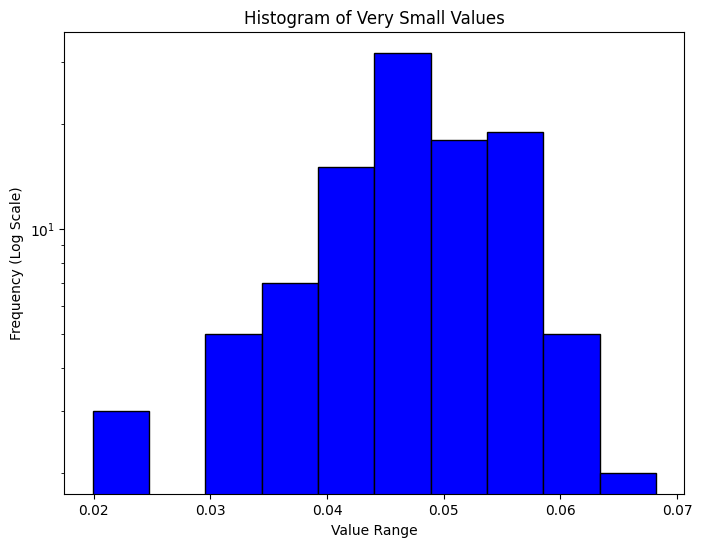

In [231]:
import matplotlib.pyplot as plt
y = np.array(y_pred)
plt.figure(figsize=(8, 6))
plt.hist(y, bins=10, color='blue', edgecolor='black', log=True)

# Adding labels and title
plt.title("Histogram of Very Small Values")
plt.xlabel("Value Range")
plt.ylabel("Frequency (Log Scale)")

# Show the histogram
plt.show()

In [212]:
y_pred  = []
y_true = []
batch = torch.zeros(23, dtype=torch.long)


with torch.no_grad():
    for graph in thors_kamp:
        output = gat(graph.x, graph.edge_index, graph.weight, batch)
        y_pred.append(output.item())
        y_true.append(graph.momentum)


RuntimeError: Expected index [23] to be smaller than self [1] apart from dimension 0 and to be smaller size than src [11]

In [232]:
y_pred  = []
y_true = []
batch = torch.zeros(23, dtype=torch.long)

with torch.no_grad():
    for graph in thors_kamp:
        output = gat(graph.x, graph.edge_index, graph.weight, batch)
        y_pred.append(output.item())
        y_true.append(graph.momentum)

x= list(range(5, 90, 5))
x.remove(45)

import matplotlib.pyplot as plt

ax = plt.axes()        
ax.yaxis.grid() 
plt.plot(x[0:8], y_pred[0:8], linestyle = 'dotted', color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[0:8], y_true[0:8], color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[8:16], y_pred[8:16], linestyle = 'dotted', color = 'cornflowerblue', linewidth = '2.5')
plt.plot(x[8:16], y_true[8:16], color = 'cornflowerblue', linewidth = '2.5')
plt.legend(["Prediction", "True"], loc="upper right")
x_ticks = list(range(0, 95, 5))
plt.xticks(ticks=x_ticks,)

plt.savefig('predictions.pdf', bbox_inches='tight')

RuntimeError: Expected index [23] to be smaller than self [1] apart from dimension 0 and to be smaller size than src [11]